In [ ]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6)
})

# Multi-step targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10)
data.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'})
data.style.set_properties(['Features'], **{'background-color': 'Lavender'})


<ipython-input-5-ed89b8456472>:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
<ipython-input-5-ed89b8456472>:5: UserWarning: Instantiating Int8Dtype without any arguments.Pass a Int8Dtype instance to silence this warning.
  ts = pd.Series(


#Example Flu Trends

In [ ]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
  # Set default color palette settings
  palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
  if palette_kwargs_ is not None:
    palette_kwargs_.update(palette_kwargs)

  # Create the color palette for plotting
  palette = sns.color_palette(**palette_kwargs_)
  if ax is None:
    fig, ax = plt.subplots()
  ax.set_prop_cycle(plt.cycler('color', palette))

  # Loop through the multistep predictions, skipping rows according to 'every'
  for date, preds in y[::every].iterrows():
    preds.index = pd.period_range(start=date, periods=len(preds))
    preds.plot(ax=ax)

  return ax


flu_trends = pd.read_csv("/content/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq='W'),
    inplace=True
)
flu_trends.drop("Week", axis=1, inplace=True)

In [ ]:
def make_lags(ts, lags, lead_time=1):
  return pd.concat(
      {
          f'y_lag_{i}': ts.shift(i)
          for i in range(lead_time, lags + lead_time)
      },
  axis=1)

# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.00)

def make_multistep_target(ts, steps):
  return pd.concat(
      {f'y_step_{i + 1}': ts.shift(-i)
      for i in range(steps)},

  axis=1)

# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shiftin has created indexes that don't match. Only keep times for indexes which have both targets and features
y, X = y.align(X, join='inner', axis=0)

In [ ]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_fit))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print((f'Train RMSE: {train_rmse:.2f}\n' f'Test RMSE: {test_rmse:.2f}'))

Train RMSE: 413.68
Test RMSE: 600.56


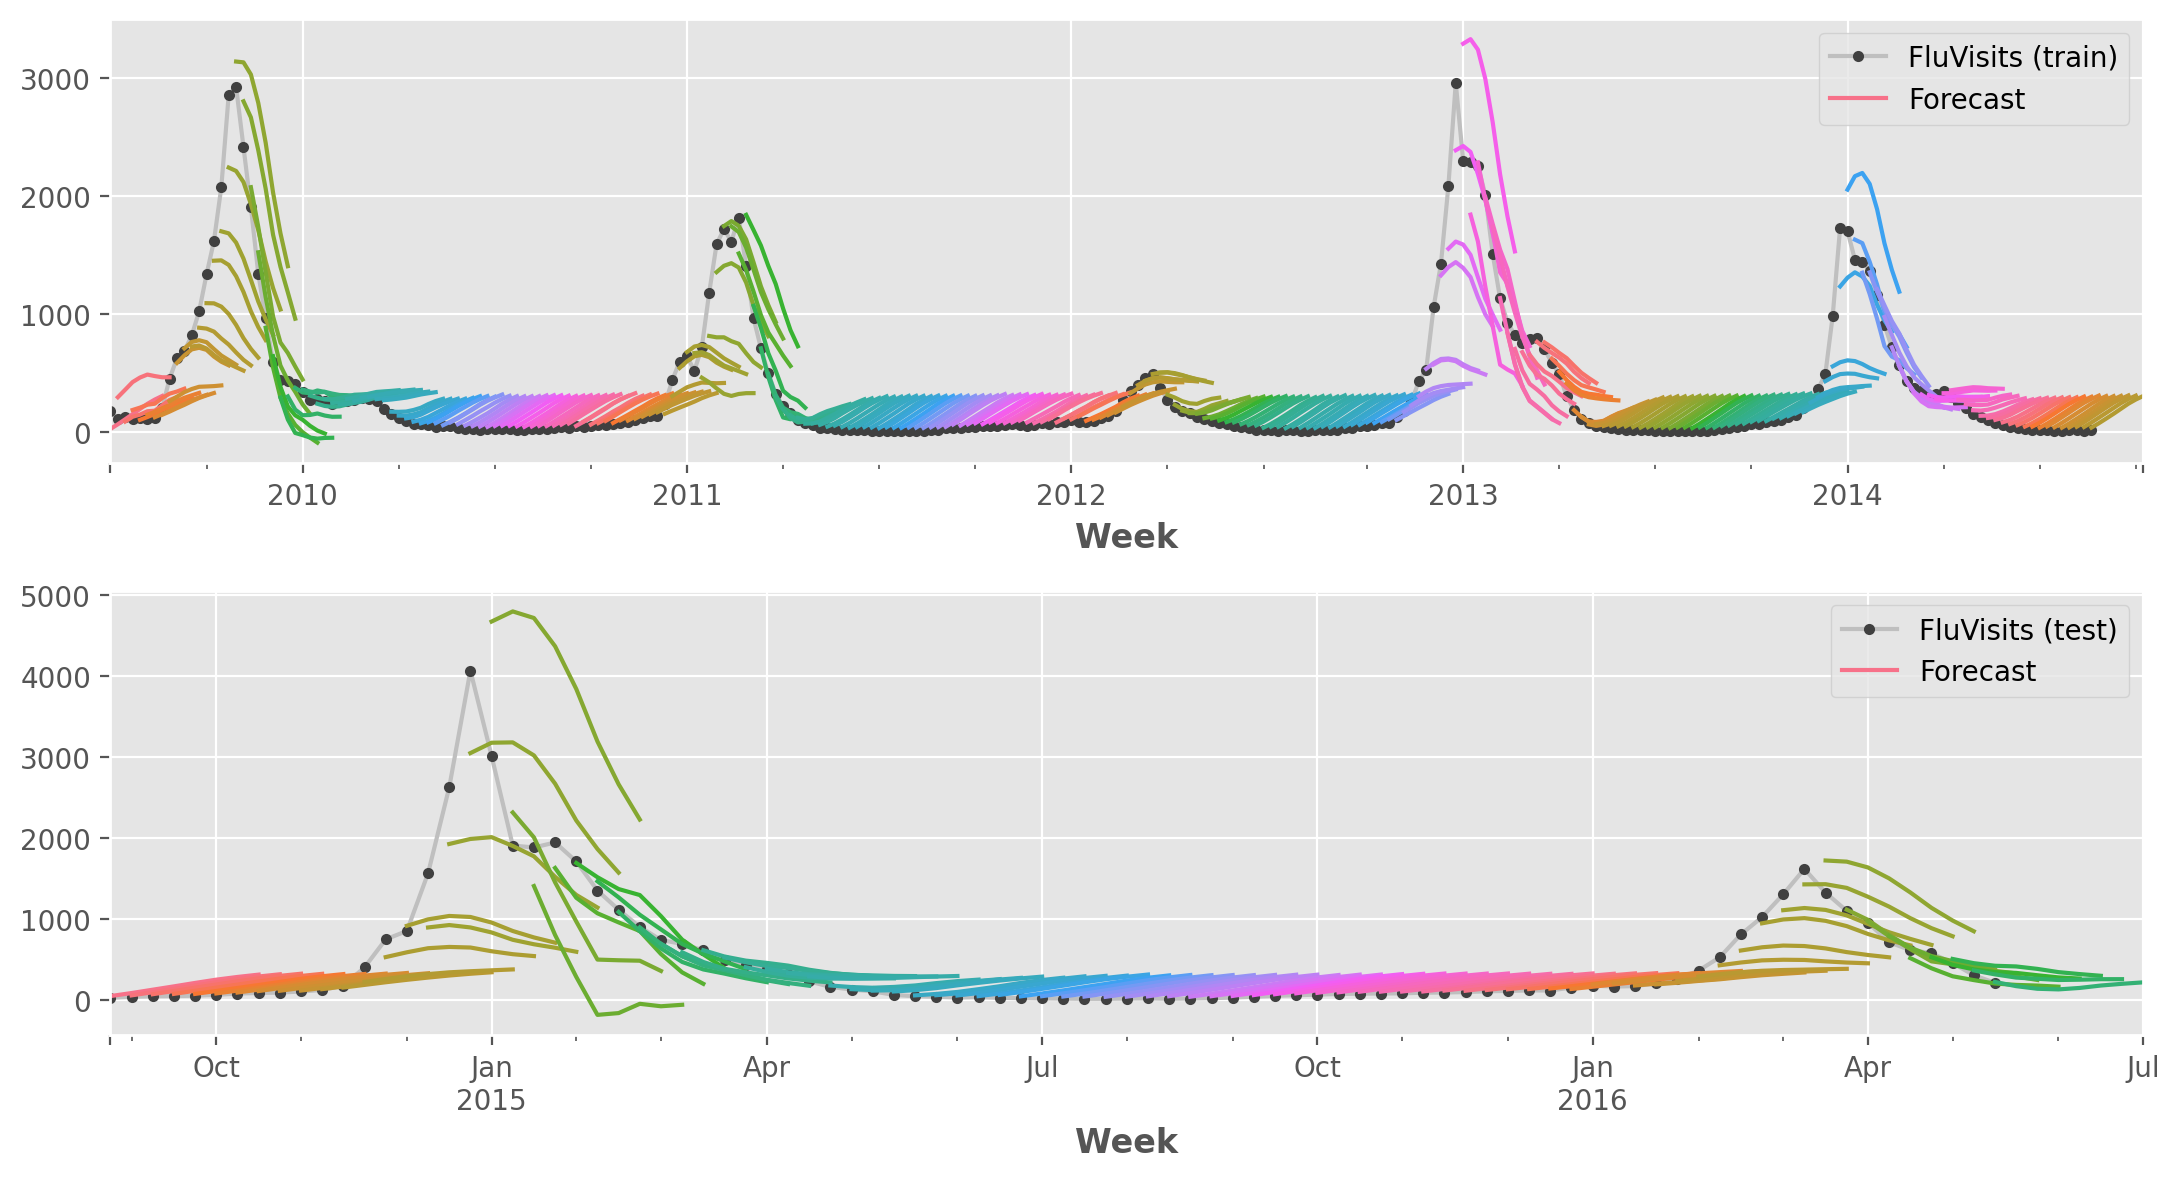

In [ ]:
palette = dict(palette='husl', n_colors=64)    # Define a color palette using seaborn's 'husl' style with 64 distinct color
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))    # Create a figure with 2 vertically stacked subplots
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)    # Plot the actual FluVisits from the training set on the first subplot (ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)   # Overlay the 8-step forecast from the training data on the same subplot
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

**Problem:**	`XGBoost` can't output multiple steps at once

**Solution:**	Use `MultiOutputRegressor` to wrap XGBoost and train one model per step

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_fit))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print((f'Train RMSE: {train_rmse:.2f}\n' f'Test RMSE: {test_rmse:.2f}'))

Train RMSE: 1.33
Test RMSE: 507.30


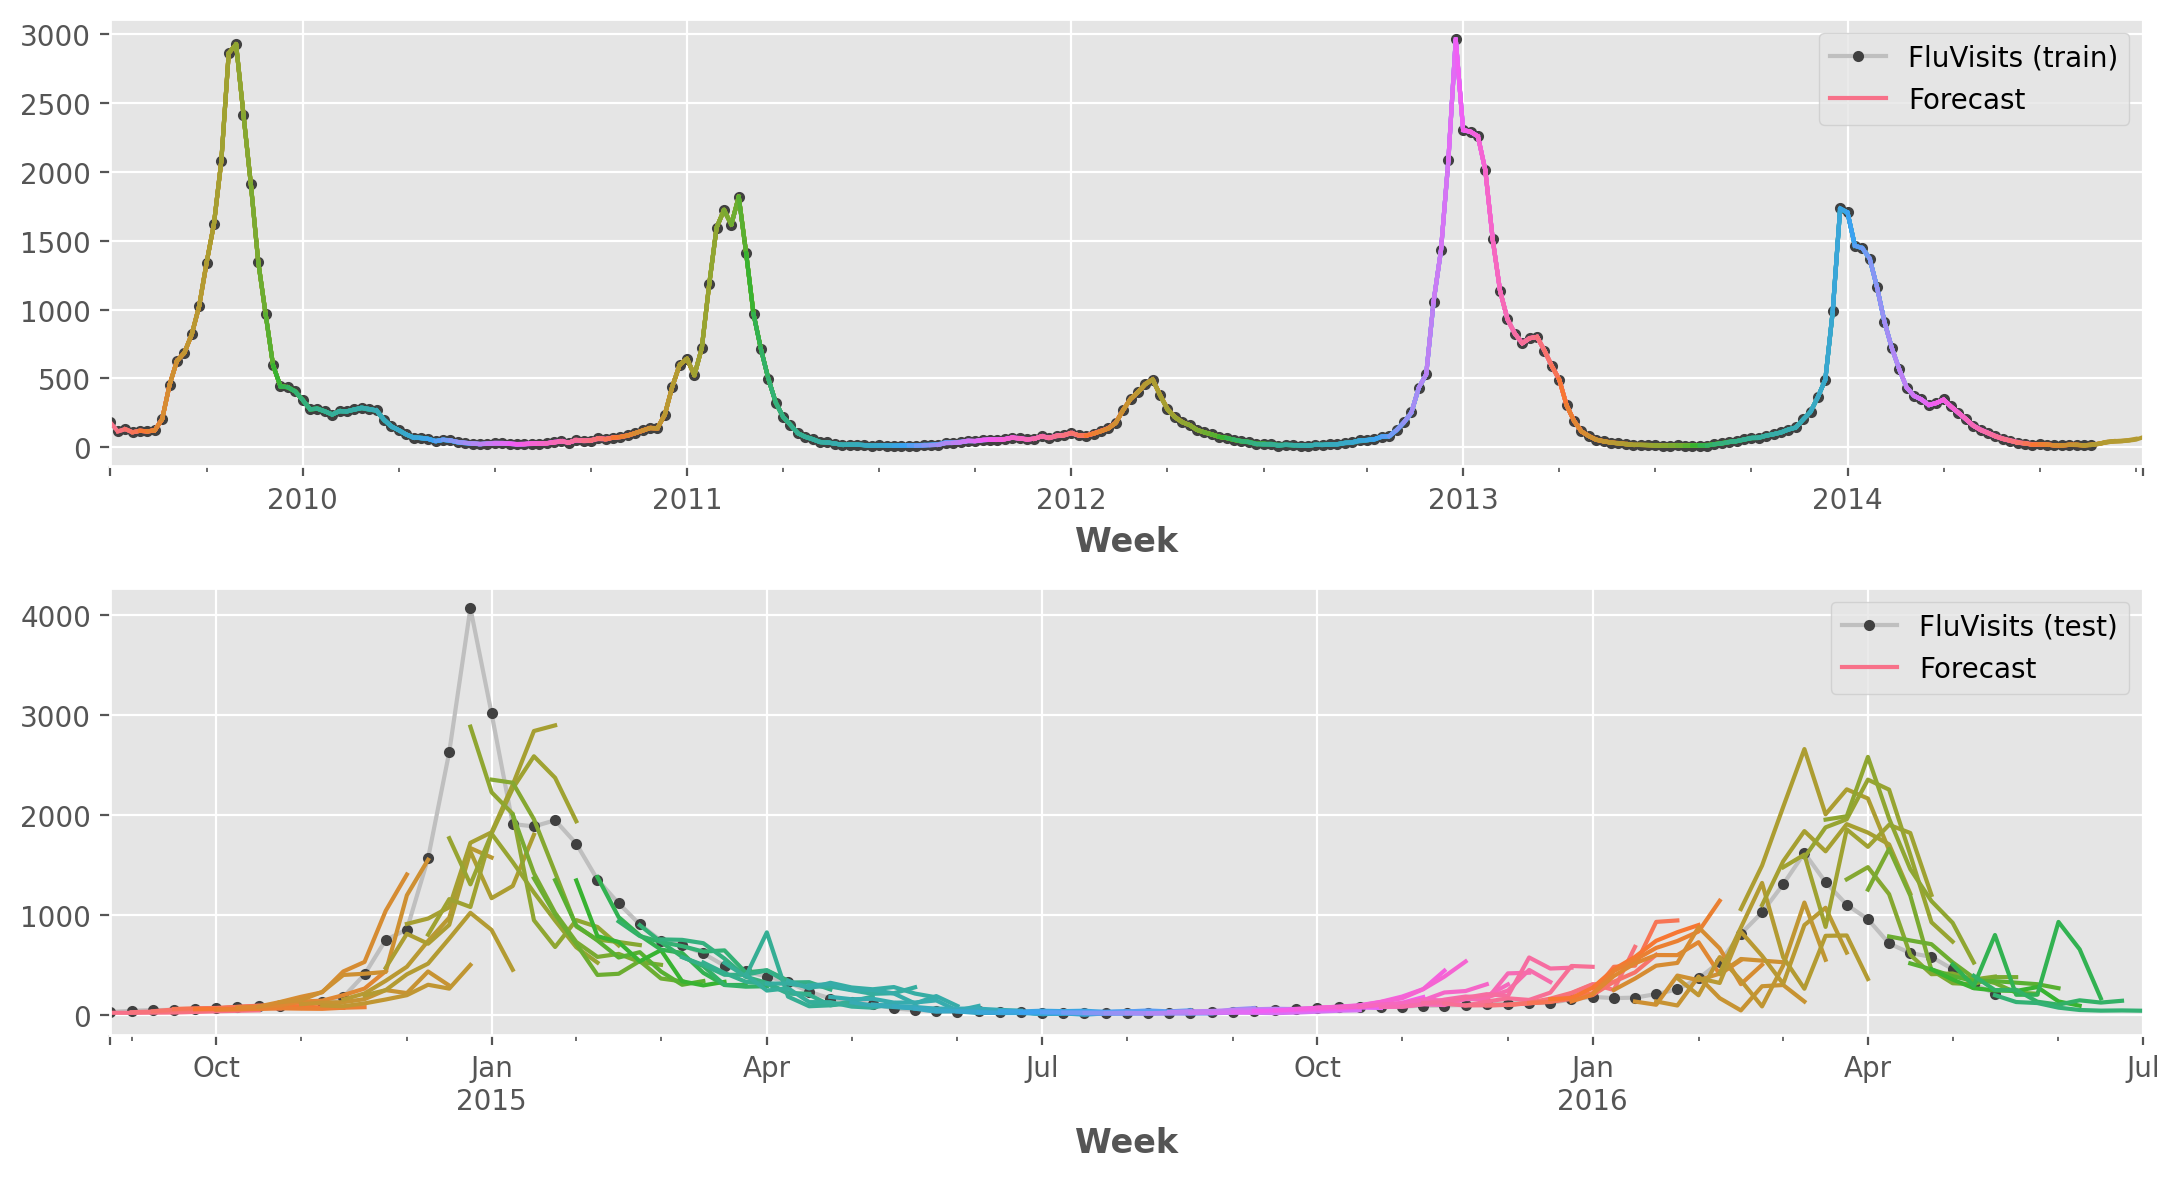

In [ ]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])

ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

# NOTES

When you're building a forecasting model, like predicting sales, weather, stock prices, etc., you must first decide two important things:

What information do you have at the time you want to make the forecast?

These are called features (or inputs).

*Example:*

If today is April 28, and you want to predict sales for May 1, you can use information you already have up to April 28, like:

Past sales

Current promotions

Current weather

Holidays

You cannot use future data (you can't know May 2's weather yet).

Everything you know up to the forecast origin is fair game to use as features.

What time period do you need forecasted values for?

This is called the target.

*Example:*

Do you want:

Tomorrow's sales? (1 step ahead)

Sales for next week? (7 steps ahead)

Sales for the next month?

The `forecast horizon` is about how far ahead you're trying to predict.

"1-step forecast": predict the very next point.

"5-step forecast": predict 5 points into the future.

The farther out you forecast, the harder it usually gets.

When you make a forecast, there is usually a gap between:

The `forecast origin` (the latest data you have), and

The `forecast horizon` (the time you are predicting for).

This gap is called the `lead time` (or sometimes latency).

##Lead time = how many time steps between the data you have and the future you are forecasting.

*Example 1:*

Immediate forecast (small lead time)

You have data up to April 28.

You want to forecast for April 29.

This is a 1-step ahead forecast (lead time = 1 step).

*Example 2:*

Forecasting farther ahead (larger lead time)

You have data up to April 28.

You want to forecast for May 2.

This is a 4-step ahead forecast (lead time = 4 steps).

Why might you need a longer lead time?

Delays in getting the latest data (e.g., sales data takes 2 days to process).

Planning needs (e.g., you must order inventory 1 week before it's needed).

Data processing time (e.g., medical lab results may take days).

In such cases, you can't always forecast just the next immediate day — you have to forecast several steps ahead.

```python
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
```        

This function `make_lags()` is designed to create lag features for a time series, which are commonly used in time series modeling (e.g., for regression or forecasting models).

##Function: `make_lags(ts, lags, lead_time=1)`
Parameters:
`ts:` The original time series (pd.Series) you want to create lags from.

`lags:` The total number of lag features to create.

`lead_time:` The number of steps ahead you are predicting (default is 1). This sets the starting lag.

##What it does:
It returns a DataFrame with lagged versions of `ts`, with column names like `y_lag_1`, `y_lag_2`, `..., up to y_lag_{lags}` — all shifted to account for the lead_time.

##How it works:
```python
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
```
It uses a dictionary comprehension to create lagged versions of `ts`.

`ts.shift(i)` moves the series down by i time steps, introducing `NaN` values at the start.

`pd.concat(..., axis=1)` combines these shifted series into a DataFrame with each lag as a column.

**Example**
```pythno
ts = pd.Series([10, 20, 30, 40, 50])
make_lags(ts, lags=3, lead_time=1)
```
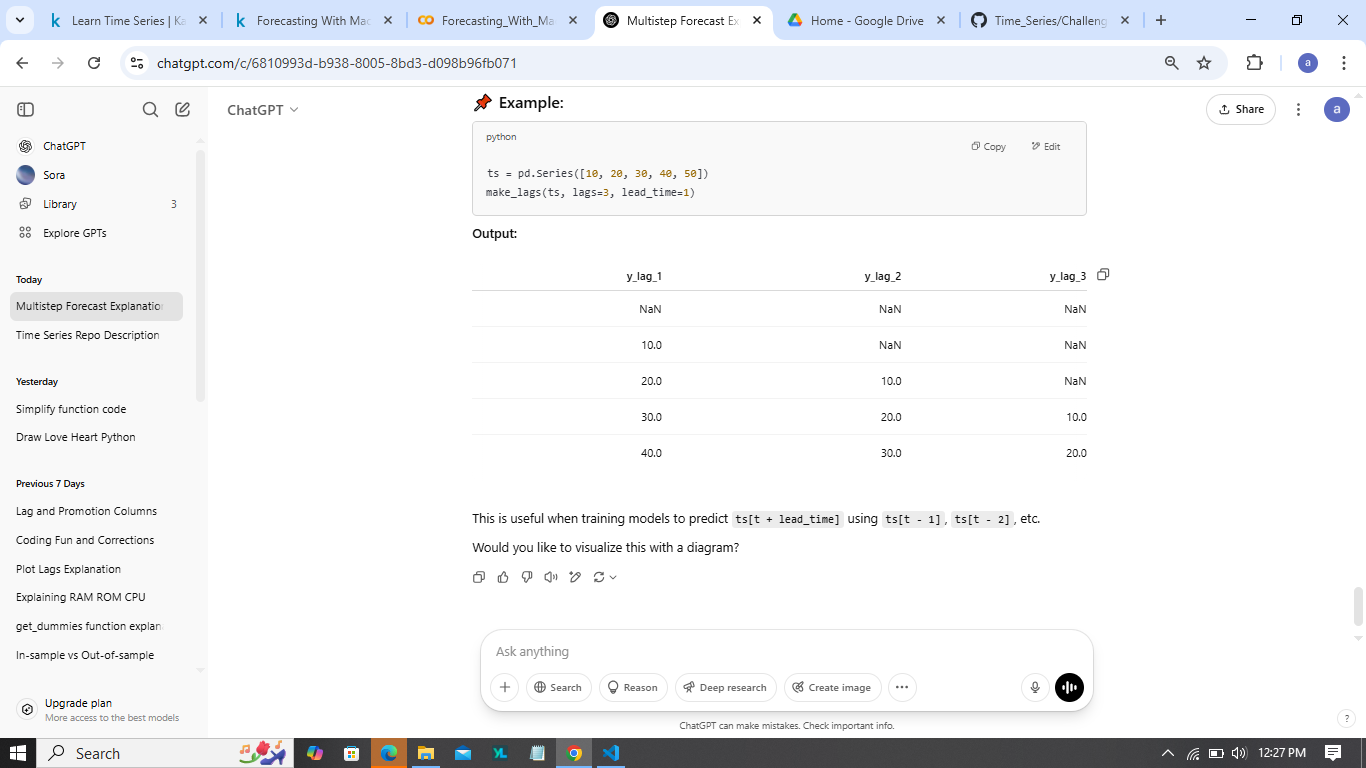